In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import optim, nn, utils
import lightning.pytorch as pl
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from utils.datagen import *


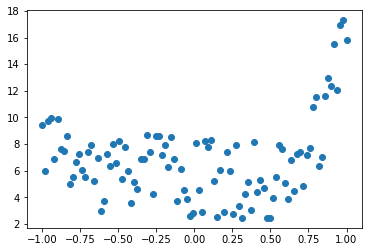

In [8]:
#generate data
n = 100
m = 200 
  
max_degree = 7
mtrx = generate_degreee_matrix(m, max_degree, 100) # [:, 0] - bias var
noise_scales = np.random.rand(m)*0.65 + 0.3

y = np.linspace(-1, 1, n)
X = polynom_feature(y, mtrx, noise_scales)

plt.scatter(y, X[:, 0])

In [9]:
X = torch.tensor(X.copy(), dtype=torch.float)
y = torch.tensor(y.copy(), dtype=torch.float)[:, None]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [10]:
X_train_mean = X_train.mean(0)
X_train_std = torch.std(X_train, dim=0)
X_test_mean = X_test.mean(0)
X_test_std = torch.std(X_test, dim=0)

X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_test_mean) / X_test_std

In [11]:
class InverseEnsembler(pl.LightningModule):
    def __init__(self, feature_dim, hidden_dim=20, lr=1e-3):
        super().__init__()
        self.automatic_optimization = False
        self.models = [nn.Sequential(nn.Linear(1, hidden_dim, 1,), 
                                     nn.ReLU(), 
                                     nn.Linear(hidden_dim, 1)) 
                                     for _ in range(feature_dim)]
        self.lr = lr
        self.params = []
        for m in self.models:
            self.params = self.params + list(m.parameters())
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        opt = self.optimizers()
        for i, m in enumerate(self.models):
            opt[i].zero_grad()
            xi_hat = m(y)
            loss = nn.functional.mse_loss(xi_hat, x[:, [i]])
            self.manual_backward(loss)
            opt[i].step()
    
    def forward(self, y):
        x_hat_list = torch.concat([m(y) for m in self.models], axis=1)
        return x_hat_list

    def configure_optimizers(self):
        optimizers = [optim.Adam(m.parameters(), lr=self.lr) for m in self.models]
        return optimizers
    

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        x_item = self.X[index]
        y_item = self.y[index]
        
        return x_item, y_item

In [16]:
batch_size = 50
shuffle = True

model = InverseEnsembler(X.shape[1], hidden_dim=100, lr=7e-2)
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)

xi, yi = next(iter(train_loader))

model.models[0](yi)

tensor([[ 0.0535],
        [-0.0490],
        [ 0.0331],
        [ 0.0614],
        [ 0.0563],
        [ 0.0090],
        [ 0.0140],
        [ 0.0600],
        [-0.0158],
        [-0.0173],
        [-0.0024],
        [ 0.0244],
        [ 0.0018],
        [-0.0434],
        [ 0.0584],
        [-0.0433],
        [-0.0047],
        [-0.0128],
        [-0.0006],
        [-0.0400],
        [-0.0415],
        [ 0.0160],
        [ 0.0304],
        [-0.0558],
        [ 0.0074],
        [-0.0424],
        [ 0.0002],
        [-0.0368],
        [ 0.0181],
        [ 0.0423],
        [-0.0457],
        [-0.0352],
        [-0.0524],
        [ 0.0600],
        [ 0.0212],
        [-0.0247],
        [-0.0213],
        [ 0.0357],
        [-0.0535],
        [ 0.0382],
        [-0.0415],
        [ 0.0449],
        [-0.0320],
        [-0.0529],
        [-0.0568],
        [ 0.0617],
        [ 0.0123],
        [-0.0249],
        [-0.0193],
        [-0.0508]], grad_fn=<AddmmBackward0>)

In [21]:
trainer = pl.Trainer(max_epochs=100, accelerator='cpu')
trainer.fit(model=model, train_dataloaders=train_loader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/shappiron/anaconda3/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
/home/shappiron/anaconda3/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/shappiron/anaconda3/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


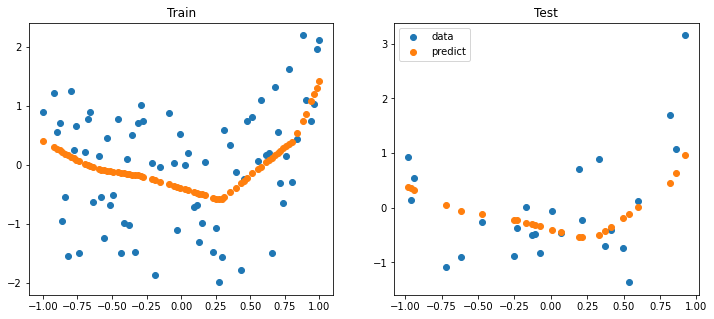

In [22]:
i = 1
x_pred_train = model.models[i](y_train).ravel().detach().numpy()
x_pred_test = model.models[i](y_test).ravel().detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(y_train.ravel().numpy(), X_train[:, i].numpy())
ax[0].scatter(y_train.ravel().numpy(), x_pred_train)
ax[1].scatter(y_test.ravel().numpy(), X_test[:, i].numpy(), label='data')
ax[1].scatter(y_test.ravel().numpy(), x_pred_test, label='predict')
ax[0].set_title('Train')
ax[1].set_title('Test')
ax[1].legend()
plt.show()

In [23]:
# check metric of trained models
res = pd.DataFrame()
for i in range(X.shape[1]):
    x_pred_train = model.models[i](y_train).ravel().detach().numpy()
    x_pred_test = model.models[i](y_test).ravel().detach().numpy()
    xi_train = X_train[:, i].numpy()
    xi_test = X_test[:, i].numpy()

    cor_train = np.corrcoef(x_pred_train, xi_train)[0,1]
    cor_test = np.corrcoef(x_pred_test, xi_test)[0,1]
    mae_train = np.mean(np.abs(x_pred_train - xi_train))
    mae_test = np.mean(np.abs(x_pred_test - xi_test))
    
    res = res.append({'r_train':cor_train, 
                      'r_test':cor_test,
                      'mae_train':mae_train, 
                      'mae_test':mae_test}, ignore_index=True)

/tmp/ipykernel_7643/2510213662.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'r_train':cor_train,
/tmp/ipykernel_7643/2510213662.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'r_train':cor_train,
/tmp/ipykernel_7643/2510213662.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'r_train':cor_train,
/tmp/ipykernel_7643/2510213662.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'r_train':cor_train,
/tmp/ipykernel_7643/2510213662.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

<AxesSubplot:xlabel='mae_train', ylabel='Density'>

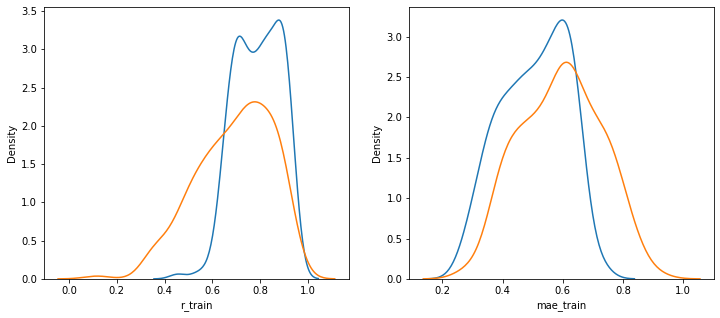

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(res['r_train'], ax=ax[0])
sns.kdeplot(res['r_test'], ax=ax[0])
sns.kdeplot(res['mae_train'], ax=ax[1])
sns.kdeplot(res['mae_test'], ax=ax[1])

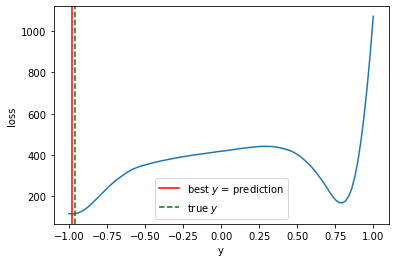

In [30]:
# combine models for prediction y
top_idx = res.sort_values('r_train', ascending=False).index#[:50]

sample_id = 10
yi_test_true = y_test[sample_id].numpy()

y_support = np.linspace(-1, 1, 100)
y_loss = []
for j, yi in enumerate(y_support):
    L = 0
    y_sup = torch.tensor([yi], dtype=torch.float)[None, :]
    for i in top_idx:
        x_pred = model.models[i](y_sup).ravel().detach().numpy()
        xi_test = X_test[sample_id, i].numpy()        
        L += (x_pred - xi_test)**2
    y_loss.append(L)

best_idx = np.argsort(np.stack(y_loss).ravel())[0]
plt.plot(y_support, y_loss)
plt.axvline(y_support[best_idx], color='red', label='best $y$ = prediction')
plt.axvline(yi_test_true, color='green', label='true $y$', ls='--')
plt.xlabel('y')
plt.ylabel('loss')
plt.legend()
plt.show()

In [42]:
top_idx = res.sort_values('r_train', ascending=False).index[:50] #50 for better performance

y_pred_test = []
y_support = np.linspace(-1, 1, 100)
for sample_id in range(y_test.shape[0]):
    yi_test_true = y_test[sample_id].numpy()
    y_loss = []
    for j, yi in enumerate(y_support):
        L = 0
        y_sup = torch.tensor([yi], dtype=torch.float)[None, :]
        for i in top_idx:
            x_pred = model.models[i](y_sup).ravel().detach().numpy()
            xi_test = X_test[sample_id, i].numpy()        
            L += (x_pred - xi_test)**2
        y_loss.append(L)
    best_idx = np.argsort(np.stack(y_loss).ravel())[0]
    y_pred_test.append(y_support[best_idx])

0.8626635289855307


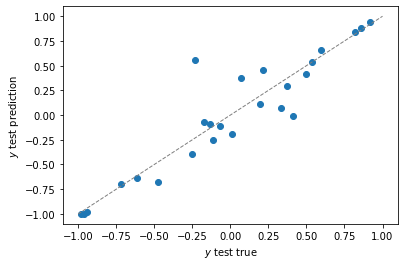

In [43]:
plt.scatter(y_test.numpy(), y_pred_test)
plt.plot([-1,1], [-1, 1], color='grey', ls='--', lw=1)
print(np.corrcoef(y_test.numpy().ravel(), y_pred_test)[0, 1]**2)
plt.xlabel('$y$ test true')
plt.ylabel('$y$ test prediction')
plt.show()